<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem, beta

import pylab as plt
plt.rcParams['figure.figsize']=(15, 8)

/home/hefesto/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cukat=pd.read_csv('data/cookie_cats.csv')

cukat.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
#Listing here all the variables needed. Total installs and retention rate at day 1 and 7 for control (30) and test (40)

install_30 = cukat[cukat.version == 'gate_30'] #44700 rows
install_40 = cukat[cukat.version == 'gate_40'] #45489 rows

day1_30 = len(install_30[install_30.retention_1 == True]) #20034 rows
day1_40 = len(install_40[install_40.retention_1 == True]) #20119 rows
day7_30 = len(install_30[install_30.retention_7 == True]) #8502 rows
day7_40 = len(install_40[install_40.retention_7 == True]) #8279 rows

#rr1_30 = day1_30/install_30 #0.448 retention rate to day 1 from install
#rr1_40 = day1_40/install_40 #0.442 retention rate to day 1 from install

rr7_30par = day7_30/day1_30 #0.424 retention rate to day 7 from day 1 
rr7_40par = day7_40/day1_40 #0.411 retention rate to day 7 from day 1 

#rr7_30tot = day7_30/len(install_30) #0.190 retention rate to day 7 from install
#rr7_40tot = day7_40/len(install_40) #0.182 retention rate to day 7 from install

In [4]:
# aprioris

a_C3, b_C3 = day7_30+1, len(install_30) - day7_30+1   # aciertos, fallos
a_T4, b_T4 = day7_40+1, len(install_40)  - day7_40+1 


beta_control = beta(a_C3, b_C3)
beta_test = beta(a_T4, b_T4)

In [17]:
x=np.linspace(0.175, 0.196, 1000)

def plot(betas, nombres):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de retencion: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

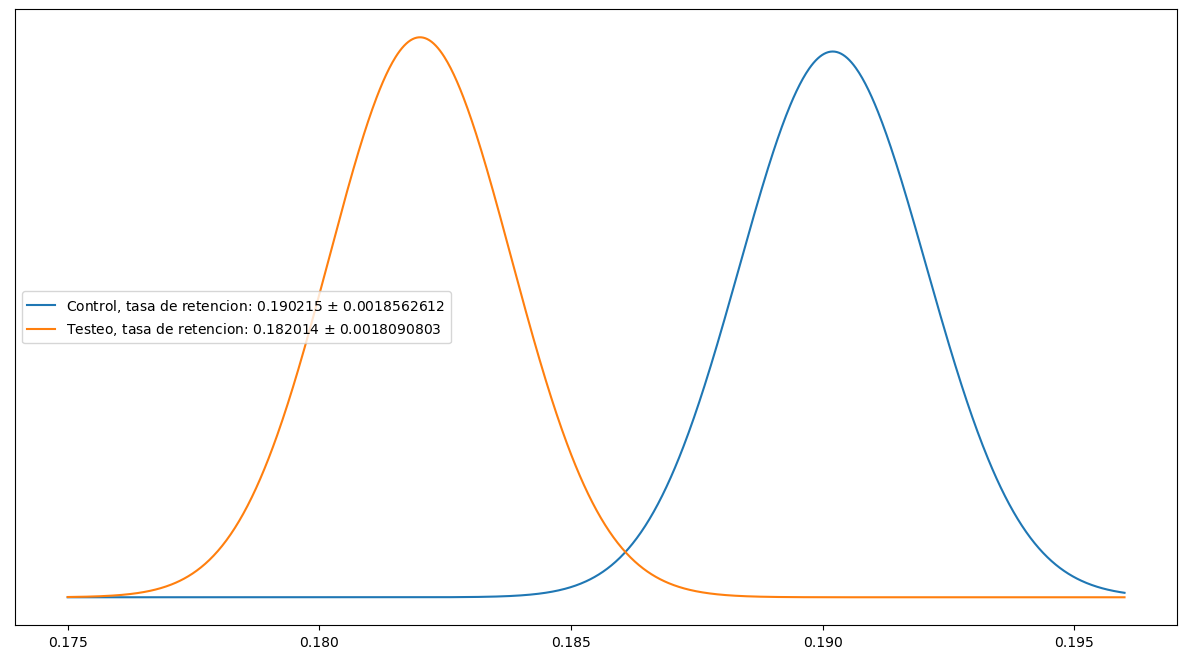

In [18]:
plot([beta_control, beta_test], ['Control', 'Testeo'])


In [20]:
salto = (beta_test.mean() - beta_control.mean())/beta_control.mean()

salto


-0.04311526114658881

In [21]:
prob = 1 - beta_test.cdf(0.186)

prob


0.014134699468777212

In [23]:
'''El test aumenta la tasa de retención en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de retención en un -4.31%, con una probabilidad del 1.41%'

In [10]:
#Comparing the users playing from day 1 to day 7, the AB testing showed that the level 40 paywal is worse than the level 30:
# 'El test aumenta la tasa de conversion en un -3.03%, con una probabilidad del 2.21%'

#When comparing users from install to day 7, lvl40 is still worse, the probability gets smaller but the retention rate gets worse:
# 'El test aumenta la tasa de retención en un -4.31%, con una probabilidad del 1.41%'
